In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Relevant Datasets

In [113]:
# Importing data
admissions_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/hosp/admissions.csv.gz')
icu_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/icu/icustays.csv.gz')
drg_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/hosp/drgcodes.csv.gz')
diag_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/hosp/diagnoses_icd.csv.gz')
d_diag_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/hosp/d_icd_diagnoses.csv.gz')
patients_df = pd.read_csv('/Users/jibuthomas/Documents/mimic-iv-2.2/hosp/patients.csv.gz')

In [114]:
drg_df.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000032,22595853,APR,283,OTHER DISORDERS OF THE LIVER,2.0,2.0
1,10000032,22595853,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
2,10000032,22841357,APR,279,HEPATIC COMA & OTHER MAJOR ACUTE LIVER DISORDERS,3.0,2.0
3,10000032,22841357,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
4,10000032,25742920,APR,283,OTHER DISORDERS OF THE LIVER,3.0,2.0


### It looks like drg type APR and HCFA gives the same information

In [115]:
# Filtering out HCFA rows
drg_df = drg_df[drg_df['drg_type'] != 'HCFA']

In [116]:
drg_df.drg_type.value_counts()

drg_type
APR    292422
Name: count, dtype: int64

In [117]:
# Figuring out the columns in the relevant datasets
def get_columns(df):
    return df.columns.tolist()

df_list = [admissions_df, icu_df, drg_df, diag_df, d_diag_df, patients_df]
df_names = ['admissions_df', 'icu_df', 'drg_df', 'diag_df', 'd_diag_df', 'patients_df']

for df, name in zip(df_list, df_names):
    print(f"Columns in {name}: {get_columns(df)}")

Columns in admissions_df: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']
Columns in icu_df: ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los']
Columns in drg_df: ['subject_id', 'hadm_id', 'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality']
Columns in diag_df: ['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']
Columns in d_diag_df: ['icd_code', 'icd_version', 'long_title']
Columns in patients_df: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']


### Target variable "los" found in icu_df

In [118]:
# Filter out patients with acute traumatic spinal cord injury
d_diag_df.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [119]:
d_diag_df[d_diag_df['long_title'].str.contains('spinal cord injury', case=False, na=False)]

,icd_code,icd_version,long_title
10006,8052,9,Closed fracture of dorsal [thoracic] vertebra ...
10007,8053,9,Open fracture of dorsal [thoracic] vertebra wi...
10008,8054,9,Closed fracture of lumbar vertebra without men...
10009,8055,9,Open fracture of lumbar vertebra without menti...
10010,8056,9,Closed fracture of sacrum and coccyx without m...
10011,8057,9,Open fracture of sacrum and coccyx without men...
10012,8058,9,Closed fracture of unspecified vertebral colum...
10013,8059,9,Open fracture of unspecified vertebral column ...
10014,80600,9,Closed fracture of C1-C4 level with unspecifie...
10018,80604,9,Closed fracture of C1-C4 level with other spec...


### To reduce patient factor variability, the prediction model will only predict ICU lengths of stay for people who experienced a spinal cord injury at the neck (ICD diagnostic codes 806.0, and 806.00 through 806.09)

In [120]:
diag_df_filtered = diag_df[diag_df['icd_code'].str.startswith('8060')]
print(diag_df_filtered.head())
print(f"Number of patients with acute traumatic spinal cord injury at the neck: {len(diag_df_filtered)}")

        subject_id   hadm_id  seq_num icd_code  icd_version
88662     10196368  24464472        1    80604            9
124710    10275408  20562387        1    80603            9
124713    10275408  20562387        4    80608            9
124912    10275551  29306218        1    80605            9
125199    10275842  21898344        1    80600            9
Number of patients with acute traumatic spinal cord injury at the neck: 158


In [121]:
# Check for duplicates in the subject_id and hadm_id columns
duplicates = diag_df_filtered[diag_df_filtered.duplicated(subset=['subject_id', 'hadm_id'], keep=False)]

# Display the duplicates if any
print(duplicates)

         subject_id   hadm_id  seq_num icd_code  icd_version
124710     10275408  20562387        1    80603            9
124713     10275408  20562387        4    80608            9
715232     11522912  22953852        1    80604            9
715237     11522912  22953852        6    80609            9
848976     11807843  28397513        1    80600            9
848984     11807843  28397513        9    80605            9
1240968    12607579  28936337        1    80604            9
1240971    12607579  28936337        4    80609            9
1384615    12916974  23183828        1    80600            9
1384626    12916974  23183828       12    80605            9
2349228    14936398  21985899        1    80600            9
2349232    14936398  21985899        5    80605            9
2364327    14973730  29551490        2    80601            9
2364329    14973730  29551490        4    80606            9
3140279    16594084  21161575        1    80600            9
3140283    16594084  211

In [122]:
len(duplicates)

30

In [123]:
# Remove duplicates based on subject_id and hadm_id
diag_df_filtered.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_83918/1366145608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df_filtered.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)


In [124]:
len(diag_df_filtered)

143

In [125]:
for df, name in zip(df_list, df_names):
    print(f"Columns in {name}: {get_columns(df)}")

Columns in admissions_df: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']
Columns in icu_df: ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los']
Columns in drg_df: ['subject_id', 'hadm_id', 'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality']
Columns in diag_df: ['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']
Columns in d_diag_df: ['icd_code', 'icd_version', 'long_title']
Columns in patients_df: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']


In [126]:
# Merge the datasets
merged_df = diag_df_filtered.merge(admissions_df, on=['subject_id', 'hadm_id'], how='left') \
                             .merge(patients_df, on='subject_id', how='left') \
                             .merge(icu_df, on=['subject_id', 'hadm_id'], how='left') \
                             .merge(drg_df, on=['subject_id', 'hadm_id'], how='left')

In [127]:
merged_df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime,admission_type,admit_provider_id,...,first_careunit,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality
0,10196368,24464472,1,80604,9,2184-05-03 13:50:00,2184-05-07 18:03:00,NaN,EW EMER.,P39FGY,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,APR,40,SPINAL DISORDERS & INJURIES,2.0,2.0
1,10275408,20562387,1,80603,9,2157-02-13 12:55:00,2157-02-20 12:50:00,NaN,EW EMER.,P77BSD,...,NaN,NaN,NaN,NaN,NaN,APR,912,MUSCULOSKELETAL & OTHER PROCEDURES FOR MULTIPL...,3.0,1.0
2,10275551,29306218,1,80605,9,2146-05-21 03:16:00,2146-05-29 16:20:00,NaN,EW EMER.,P23Y5G,...,NaN,NaN,NaN,NaN,NaN,APR,40,SPINAL DISORDERS & INJURIES,4.0,2.0
3,10275842,21898344,1,80600,9,2170-01-14 06:18:00,2170-01-22 16:58:00,NaN,EW EMER.,P462X1,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,2.0,1.0
4,10348324,27926100,1,80608,9,2137-06-29 20:21:00,2137-07-06 14:50:00,NaN,EW EMER.,P93E1Z,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,APR,23,SPINAL PROCEDURES,2.0,1.0


In [128]:
merged_df.shape

(150, 35)

In [129]:
# Filter Duplicates
duplicates = merged_df[merged_df.duplicated(subset=['subject_id', 'hadm_id'], keep=False)]

# Check if there are any duplicates
if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")

Duplicates found:
     subject_id   hadm_id  seq_num icd_code  icd_version            admittime  \
28     12324075  24304637        1    80605            9  2122-03-02 20:13:00   
29     12324075  24304637        1    80605            9  2122-03-02 20:13:00   
30     12324075  24304637        1    80605            9  2122-03-02 20:13:00   
39     13096583  20322847        1    80605            9  2167-07-30 18:01:00   
40     13096583  20322847        1    80605            9  2167-07-30 18:01:00   
60     14309442  21702831        1    80609            9  2183-07-23 01:20:00   
61     14309442  21702831        1    80609            9  2183-07-23 01:20:00   
91     16207680  24977761        1    80601            9  2154-07-17 21:25:00   
92     16207680  24977761        1    80601            9  2154-07-17 21:25:00   
93     16207680  24977761        1    80601            9  2154-07-17 21:25:00   
126    18651030  20582772        1    80608            9  2113-02-16 06:49:00   
127    186

In [130]:
duplicates

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,deathtime,admission_type,admit_provider_id,...,first_careunit,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality
28,12324075,24304637,1,80605,9,2122-03-02 20:13:00,2122-03-28 16:00:00,NaN,EW EMER.,P26BSW,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2122-03-03 11:32:10,2122-03-11 18:17:09,8.281238,APR,23,SPINAL PROCEDURES,3.0,3.0
29,12324075,24304637,1,80605,9,2122-03-02 20:13:00,2122-03-28 16:00:00,NaN,EW EMER.,P26BSW,...,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2122-03-12 03:52:25,2122-03-12 09:29:22,0.233993,APR,23,SPINAL PROCEDURES,3.0,3.0
30,12324075,24304637,1,80605,9,2122-03-02 20:13:00,2122-03-28 16:00:00,NaN,EW EMER.,P26BSW,...,Coronary Care Unit (CCU),Trauma SICU (TSICU),2122-03-12 10:13:09,2122-03-26 17:48:24,14.316146,APR,23,SPINAL PROCEDURES,3.0,3.0
39,13096583,20322847,1,80605,9,2167-07-30 18:01:00,2167-08-10 12:30:00,NaN,EW EMER.,P39FGY,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2167-08-04 10:56:29,2167-08-10 12:40:26,6.072188,APR,23,SPINAL PROCEDURES,3.0,3.0
40,13096583,20322847,1,80605,9,2167-07-30 18:01:00,2167-08-10 12:30:00,NaN,EW EMER.,P39FGY,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2167-07-30 18:22:00,2167-08-02 16:36:02,2.926412,APR,23,SPINAL PROCEDURES,3.0,3.0
60,14309442,21702831,1,80609,9,2183-07-23 01:20:00,2183-08-13 16:13:00,NaN,EW EMER.,P01LRQ,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2183-08-06 21:36:06,2183-08-07 16:23:10,0.782685,APR,23,SPINAL PROCEDURES,3.0,2.0
61,14309442,21702831,1,80609,9,2183-07-23 01:20:00,2183-08-13 16:13:00,NaN,EW EMER.,P01LRQ,...,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2183-07-23 02:11:00,2183-07-28 20:06:15,5.746701,APR,23,SPINAL PROCEDURES,3.0,2.0
91,16207680,24977761,1,80601,9,2154-07-17 21:25:00,2154-09-15 12:42:00,NaN,EW EMER.,P99LA7,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-08-13 16:12:08,2154-08-23 21:09:58,10.206829,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0
92,16207680,24977761,1,80601,9,2154-07-17 21:25:00,2154-09-15 12:42:00,NaN,EW EMER.,P99LA7,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-07-17 21:48:00,2154-08-04 14:29:23,17.695405,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0
93,16207680,24977761,1,80601,9,2154-07-17 21:25:00,2154-09-15 12:42:00,NaN,EW EMER.,P99LA7,...,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-08-05 18:28:36,2154-08-07 19:37:44,2.048009,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0


In [131]:
# Remove duplicates based on subject_id and hadm_id
merged_df.drop_duplicates(subset=['subject_id', 'hadm_id'], inplace=True)  
print(f"Shape after removing duplicates: {merged_df.shape}")

Shape after removing duplicates: (143, 35)


In [132]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admit_provider_id', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'gender', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'stay_id', 'first_careunit',
       'last_careunit', 'intime', 'outtime', 'los', 'drg_type', 'drg_code',
       'description', 'drg_severity', 'drg_mortality'],
      dtype='object')

In [133]:
# Check for null values in the merged DataFrame
null_percentage = merged_df.isnull().mean() * 100
print(null_percentage[null_percentage > 0])

deathtime         88.111888
marital_status    15.384615
edregtime          4.895105
edouttime          4.895105
dod               73.426573
stay_id           37.062937
first_careunit    37.062937
last_careunit     37.062937
intime            37.062937
outtime           37.062937
los               37.062937
dtype: float64


In [134]:
# Remove the dod column 
merged_df.drop(columns=['dod'], inplace=True, errors='ignore')

In [135]:
# Remove the deathtime column
merged_df.drop(columns=['deathtime'], inplace=True, errors='ignore')

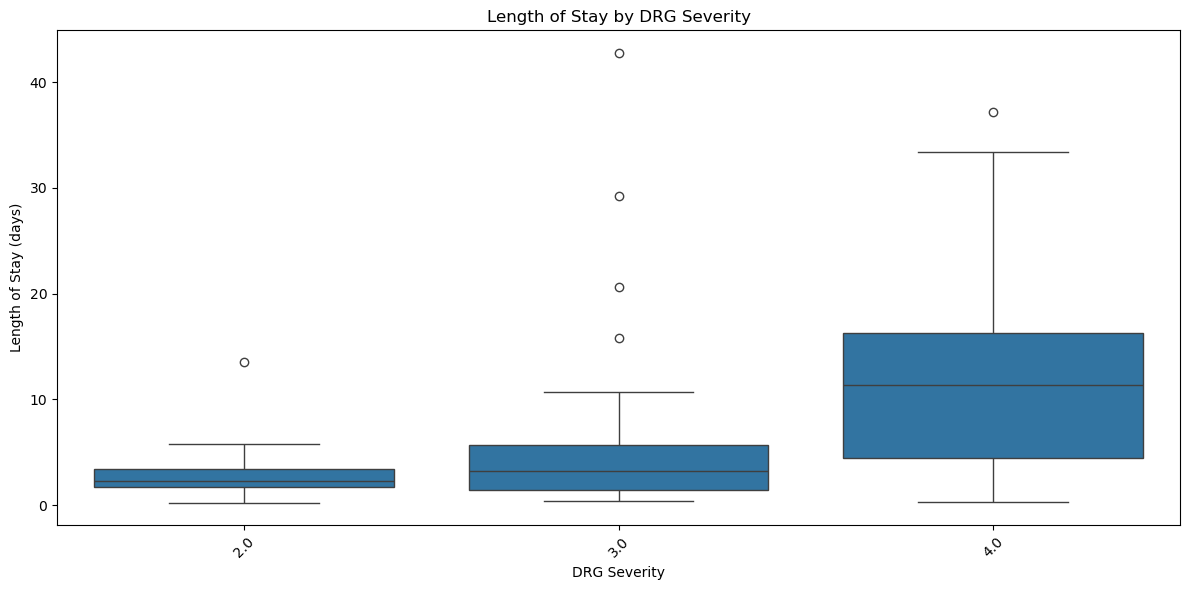

In [136]:
# Visualize the relatonship between drg_severity and los
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='drg_severity', y='los')
plt.title('Length of Stay by DRG Severity')
plt.xlabel('DRG Severity')
plt.ylabel('Length of Stay (days)')
plt.xticks(rotation=45)
plt.tight_layout()

In [137]:
merged_df[merged_df['los'].isnull()]

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,admission_type,admit_provider_id,admission_location,...,first_careunit,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality
1,10275408,20562387,1,80603,9,2157-02-13 12:55:00,2157-02-20 12:50:00,EW EMER.,P77BSD,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,912,MUSCULOSKELETAL & OTHER PROCEDURES FOR MULTIPL...,3.0,1.0
2,10275551,29306218,1,80605,9,2146-05-21 03:16:00,2146-05-29 16:20:00,EW EMER.,P23Y5G,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,40,SPINAL DISORDERS & INJURIES,4.0,2.0
3,10275842,21898344,1,80600,9,2170-01-14 06:18:00,2170-01-22 16:58:00,EW EMER.,P462X1,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,2.0,1.0
8,10612095,24845894,1,80605,9,2166-10-04 23:55:00,2166-10-10 17:14:00,EW EMER.,P39043,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,3.0,3.0
11,10891267,21920117,1,80600,9,2112-05-12 02:30:00,2112-05-16 15:53:00,URGENT,P26BSW,TRANSFER FROM SKILLED NURSING FACILITY,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,3.0,1.0
14,10965423,29556899,1,80605,9,2129-09-14 22:41:00,2129-09-15 17:16:00,EW EMER.,P13ZRJ,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,40,SPINAL DISORDERS & INJURIES,2.0,1.0
15,11072575,20225342,1,80605,9,2148-01-18 11:15:00,2148-01-19 13:00:00,SURGICAL SAME DAY ADMISSION,P26BSW,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,3.0,1.0
18,11384260,27144550,2,80609,9,2198-06-05 18:48:00,2198-06-16 17:30:00,EW EMER.,P886Y0,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,4.0,3.0
21,11796891,20461701,2,80600,9,2161-01-31 03:16:00,2161-02-02 13:15:00,URGENT,P87SDH,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,NaN,APR,57,"CONCUSSION, CLOSED SKULL FX NOS,UNCOMPLICATED ...",3.0,2.0
24,12000187,23597100,1,80604,9,2149-10-20 05:14:00,2149-10-24 11:38:00,EW EMER.,P26BSW,EMERGENCY ROOM,...,NaN,NaN,NaN,NaN,NaN,APR,23,SPINAL PROCEDURES,3.0,2.0


In [138]:
#Drop rows where los is missing
merged_df.dropna(subset=['los'], inplace=True)

In [139]:
merged_df.shape

(90, 33)

In [140]:
merged_df.marital_status.value_counts()

marital_status
MARRIED     35
SINGLE      24
WIDOWED      6
DIVORCED     3
Name: count, dtype: int64

In [141]:
# Check for null values in the merged DataFrame
null_percentage = merged_df.isnull().mean() * 100
print(null_percentage[null_percentage > 0])

marital_status    24.444444
edregtime          3.333333
edouttime          3.333333
dtype: float64


In [142]:
import pandas as pd

# Replace null values in 'marital_status' with 'unknown'
merged_df['marital_status'] = merged_df['marital_status'].fillna('unknown')

In [143]:
#Create a new column which indicates the ED llos
# Convert edregtime and edouttime to datetime objects
merged_df['edregtime'] = pd.to_datetime(merged_df['edregtime'], errors='coerce')
merged_df['edouttime'] = pd.to_datetime(merged_df['edouttime'], errors='coerce')

# Check data types
print(merged_df[['edregtime', 'edouttime']].dtypes)

# Calculate the length of stay in the ED
merged_df['ed_los'] = (merged_df['edouttime'] - merged_df['edregtime']).dt.total_seconds() / 60  # Convert to minutes

edregtime    datetime64[ns]
edouttime    datetime64[ns]
dtype: object


In [144]:
merged_df['ed_los']

0      658.0
4      372.0
5      384.0
6      183.0
7      212.0
       ...  
143    416.0
144    156.0
145    118.0
146    120.0
149    530.0
Name: ed_los, Length: 90, dtype: float64

In [145]:
merged_df[merged_df['ed_los'].isnull()]

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,admission_type,admit_provider_id,admission_location,...,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality,ed_los
59,14061397,26940614,1,80600,9,2154-07-09 17:16:00,2154-07-17 14:46:00,URGENT,P84V08,TRANSFER FROM SKILLED NURSING FACILITY,...,Trauma SICU (TSICU),2154-07-12 15:19:05,2154-07-15 18:34:27,3.135671,APR,23,SPINAL PROCEDURES,3.0,3.0,NaN
76,15347247,29821193,3,80605,9,2133-07-11 20:49:00,2133-07-20 14:46:00,URGENT,P73RXE,TRANSFER FROM HOSPITAL,...,Medical Intensive Care Unit (MICU),2133-07-11 20:49:59,2133-07-12 21:25:02,1.024340,APR,321,CERVICAL SPINAL FUSION & OTHER BACK/NECK PROC ...,4.0,3.0,NaN
83,15773840,28363075,1,80609,9,2176-01-04 01:14:00,2176-02-03 10:13:00,URGENT,P77BSD,TRANSFER FROM HOSPITAL,...,Trauma SICU (TSICU),2176-01-04 01:19:47,2176-02-03 11:16:04,30.414086,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,4.0,NaN


In [146]:
merged_df[merged_df['ed_los'].isnull() == False]

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,admission_type,admit_provider_id,admission_location,...,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality,ed_los
0,10196368,24464472,1,80604,9,2184-05-03 13:50:00,2184-05-07 18:03:00,EW EMER.,P39FGY,EMERGENCY ROOM,...,Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,APR,40,SPINAL DISORDERS & INJURIES,2.0,2.0,658.0
4,10348324,27926100,1,80608,9,2137-06-29 20:21:00,2137-07-06 14:50:00,EW EMER.,P93E1Z,EMERGENCY ROOM,...,Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,APR,23,SPINAL PROCEDURES,2.0,1.0,372.0
5,10393331,21425859,1,80600,9,2114-03-27 00:01:00,2114-04-13 10:00:00,EW EMER.,P01LRQ,EMERGENCY ROOM,...,Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0,384.0
6,10441044,21256821,3,80605,9,2165-06-19 01:58:00,2165-07-09 14:45:00,EW EMER.,P19SWB,EMERGENCY ROOM,...,Trauma SICU (TSICU),2165-06-19 03:27:00,2165-07-03 00:41:08,13.884815,APR,912,MUSCULOSKELETAL & OTHER PROCEDURES FOR MULTIPL...,4.0,3.0,183.0
7,10521666,28942795,1,80605,9,2176-03-24 08:24:00,2176-04-22 14:30:00,EW EMER.,P01T18,EMERGENCY ROOM,...,Trauma SICU (TSICU),2176-03-24 09:29:00,2176-04-22 14:43:34,29.218449,APR,23,SPINAL PROCEDURES,3.0,3.0,212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,19691709,22078567,1,80605,9,2169-11-05 02:26:00,2169-11-07 13:00:00,EW EMER.,P34SFE,EMERGENCY ROOM,...,Trauma SICU (TSICU),2169-11-05 02:28:15,2169-11-05 18:50:08,0.681863,APR,40,SPINAL DISORDERS & INJURIES,2.0,1.0,416.0
144,19739493,23894396,1,80600,9,2172-10-20 17:42:00,2172-10-21 22:01:00,EW EMER.,P77TVG,EMERGENCY ROOM,...,Trauma SICU (TSICU),2172-10-20 18:41:00,2172-10-25 11:10:08,4.686898,APR,950,EXTENSIVE PROCEDURE UNRELATED TO PRINCIPAL DIA...,4.0,4.0,156.0
145,19752825,25712095,7,80604,9,2112-01-06 21:16:00,2112-01-10 19:31:00,EW EMER.,P19SWB,EMERGENCY ROOM,...,Trauma SICU (TSICU),2112-01-06 22:19:00,2112-01-10 22:20:28,4.001019,APR,930,MULTIPLE SIGNIFICANT TRAUMA W/O O.R. PROCEDURE,4.0,4.0,118.0
146,19788979,28470391,1,80609,9,2113-01-29 01:43:00,2113-02-13 10:45:00,EW EMER.,P19SWB,EMERGENCY ROOM,...,Trauma SICU (TSICU),2113-01-29 01:44:31,2113-02-13 11:34:05,15.409421,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,2.0,120.0


In [147]:
# Imput null values in ed_los to 0 and remove edregtime and edouttime
merged_df['ed_los'] = merged_df['ed_los'].fillna(0)
merged_df = merged_df.drop(columns=['edregtime', 'edouttime'])

In [148]:
# Check for null values in the merged DataFrame
null_percentage = merged_df.isnull().mean() * 100
print(null_percentage[null_percentage > 0])

Series([], dtype: float64)


In [149]:
# Column data types
data_types = merged_df.dtypes
print(data_types)

subject_id                int64
hadm_id                   int64
seq_num                   int64
icd_code                 object
icd_version               int64
admittime                object
dischtime                object
admission_type           object
admit_provider_id        object
admission_location       object
discharge_location       object
insurance                object
language                 object
marital_status           object
race                     object
hospital_expire_flag      int64
gender                   object
anchor_age                int64
anchor_year               int64
anchor_year_group        object
stay_id                 float64
first_careunit           object
last_careunit            object
intime                   object
outtime                  object
los                     float64
drg_type                 object
drg_code                  int64
description              object
drg_severity            float64
drg_mortality           float64
ed_los  

In [150]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'admittime', 'dischtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'stay_id',
       'first_careunit', 'last_careunit', 'intime', 'outtime', 'los',
       'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality',
       'ed_los'],
      dtype='object')

In [151]:
merged_df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime,dischtime,admission_type,admit_provider_id,admission_location,...,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality,ed_los
0,10196368,24464472,1,80604,9,2184-05-03 13:50:00,2184-05-07 18:03:00,EW EMER.,P39FGY,EMERGENCY ROOM,...,Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,APR,40,SPINAL DISORDERS & INJURIES,2.0,2.0,658.0
4,10348324,27926100,1,80608,9,2137-06-29 20:21:00,2137-07-06 14:50:00,EW EMER.,P93E1Z,EMERGENCY ROOM,...,Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,APR,23,SPINAL PROCEDURES,2.0,1.0,372.0
5,10393331,21425859,1,80600,9,2114-03-27 00:01:00,2114-04-13 10:00:00,EW EMER.,P01LRQ,EMERGENCY ROOM,...,Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0,384.0
6,10441044,21256821,3,80605,9,2165-06-19 01:58:00,2165-07-09 14:45:00,EW EMER.,P19SWB,EMERGENCY ROOM,...,Trauma SICU (TSICU),2165-06-19 03:27:00,2165-07-03 00:41:08,13.884815,APR,912,MUSCULOSKELETAL & OTHER PROCEDURES FOR MULTIPL...,4.0,3.0,183.0
7,10521666,28942795,1,80605,9,2176-03-24 08:24:00,2176-04-22 14:30:00,EW EMER.,P01T18,EMERGENCY ROOM,...,Trauma SICU (TSICU),2176-03-24 09:29:00,2176-04-22 14:43:34,29.218449,APR,23,SPINAL PROCEDURES,3.0,3.0,212.0


In [152]:
merged_df.shape

(90, 32)

#### Only 90 rows of data, we need to get data form the MIMIC-III dataset

In [153]:
# Importing mimic3 data
admissions_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz')
icu_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz')
drg_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/DRGCODES.csv.gz')
diag_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz')
d_diag_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz')
patients_mimic3 = pd.read_csv('/Users/jibuthomas/Documents/mimic-iii-clinical-database-1.4/PATIENTS.csv.gz')

In [154]:
# Filtering out HCFA rows
drg_mimic3 = drg_mimic3[drg_mimic3['DRG_TYPE'] != 'HCFA']

In [155]:
drg_mimic3.DRG_TYPE.value_counts()

DRG_TYPE
APR     66634
MS      27279
Name: count, dtype: int64

In [156]:
drg_df.drg_type.value_counts()

drg_type
APR    292422
Name: count, dtype: int64

In [157]:
drg_mimic3 = drg_mimic3[drg_mimic3['DRG_TYPE'] != 'MS']

In [158]:
drg_mimic3.DRG_TYPE.value_counts()

DRG_TYPE
APR     66634
Name: count, dtype: int64

In [159]:
diag_mimic3.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [160]:
diag_mimic3_filtered = diag_mimic3[diag_mimic3['ICD9_CODE'].str.startswith('8060',  na=False)]
print(diag_df_filtered.head())

        subject_id   hadm_id  seq_num icd_code  icd_version
88662     10196368  24464472        1    80604            9
124710    10275408  20562387        1    80603            9
124912    10275551  29306218        1    80605            9
125199    10275842  21898344        1    80600            9
162323    10348324  27926100        1    80608            9


In [161]:
df_list = [admissions_mimic3, icu_mimic3, drg_mimic3, diag_mimic3, d_diag_mimic3, patients_mimic3]
df_names = ['admissions_mimic3', 'icu_mimic3', 'drg_mimic3', 'diag_mimic3', 'd_diag_mimic3', 'patients_mimic3']

for df, name in zip(df_list, df_names):
    print(f"Columns in {name}: {get_columns(df)}")

Columns in admissions_mimic3: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
Columns in icu_mimic3: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME', 'LOS']
Columns in drg_mimic3: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'DRG_TYPE', 'DRG_CODE', 'DESCRIPTION', 'DRG_SEVERITY', 'DRG_MORTALITY']
Columns in diag_mimic3: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']
Columns in d_diag_mimic3: ['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']
Columns in patients_mimic3: ['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG']


In [162]:
# Merge the datasets
merged_mimic3df = diag_mimic3_filtered.merge(admissions_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left') \
                             .merge(patients_mimic3, on='SUBJECT_ID', how='left') \
                             .merge(icu_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left') \
                             .merge(drg_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left')

MergeError: Passing 'suffixes' which cause duplicate columns {'ROW_ID_x'} is not allowed.

In [163]:
# Delete ROW ID column
for df in df_list:
    if 'ROW_ID' in df.columns:
        df.drop(columns=['ROW_ID'], inplace=True, errors='ignore')

In [164]:
diag_mimic3_filtered.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
1582,2140,175,159223,1.0,80604
5060,3370,285,165312,2.0,80605
7394,6625,570,100913,1.0,80607
11016,10284,882,163612,3.0,80605
16202,16729,1479,115916,1.0,80605


In [165]:
diag_mimic3_filtered.drop(columns=['ROW_ID'], inplace=True, errors='ignore')

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_83918/548224588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_mimic3_filtered.drop(columns=['ROW_ID'], inplace=True, errors='ignore')


In [166]:
diag_mimic3_filtered.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
1582,175,159223,1.0,80604
5060,285,165312,2.0,80605
7394,570,100913,1.0,80607
11016,882,163612,3.0,80605
16202,1479,115916,1.0,80605


In [167]:
# Check for duplicates in the subject_id and hadm_id columns
duplicates = diag_mimic3_filtered[diag_mimic3_filtered.duplicated(subset=['SUBJECT_ID', 'HADM_ID'], keep=False)]

# Display the duplicates if any
print(duplicates)

        SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
87138         7689   124463      1.0     80604
87139         7689   124463      2.0     80609
119073       11520   157511      1.0     80600
119082       11520   157511     10.0     80605
150715       12745   184515      2.0     80600
150716       12745   184515      3.0     80605
213708       21068   138137      1.0     80600
213717       21068   138137     10.0     80605
232369       19698   199543      1.0     80600
232375       19698   199543      7.0     80605
258386       22482   190379      1.0     80609
258391       22482   190379      6.0     80604
258409       22485   108241      1.0     80600
258418       22485   108241     10.0     80605
269637       23523   179699      1.0     80603
269638       23523   179699      2.0     80608
334294       28744   108474      1.0     80603
334309       28744   108474     16.0     80608
443268       56130   114902      1.0     80604
443270       56130   114902      3.0     80609
457795       

In [168]:
len(diag_mimic3_filtered)

171

In [169]:
# Remove duplicates based on subject_id and hadm_id
diag_mimic3_filtered.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], inplace=True)

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_83918/582393953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_mimic3_filtered.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], inplace=True)


In [170]:
len(diag_mimic3_filtered)

155

In [171]:
# Merge the datasets
merged_mimic3df = diag_mimic3_filtered.merge(admissions_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left') \
                             .merge(patients_mimic3, on='SUBJECT_ID', how='left') \
                             .merge(icu_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left') \
                             .merge(drg_mimic3, on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [172]:
merged_mimic3df.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,175,159223,1.0,80604,2183-10-30 23:06:00,2183-11-11 13:25:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,57.0,57.0,2183-10-30 23:07:16,2183-11-01 20:38:54,1.8970,APR,403.0,Spinal Disorders & Injuries,3.0,2.0
1,285,165312,2.0,80605,2152-09-21 22:47:00,2152-10-20 15:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,14.0,14.0,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,APR,44.0,Tracheostomy W Long Term Mechanical Ventilatio...,4.0,4.0
2,570,100913,1.0,80607,2181-01-15 10:57:00,2181-01-18 16:22:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,...,14.0,14.0,2181-01-15 10:58:05,2181-01-16 18:46:53,1.3256,APR,232.0,Spinal Procedures,2.0,1.0
3,882,163612,3.0,80605,2133-05-27 19:08:00,2133-06-03 18:39:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,14.0,14.0,2133-05-27 19:10:38,2133-05-28 20:18:42,1.0473,APR,9123.0,Musculoskeletal & Other Procedures For Multipl...,3.0,3.0
4,1479,115916,1.0,80605,2157-11-08 15:21:00,2157-12-12 13:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,57.0,57.0,2157-11-08 15:22:58,2157-12-06 21:09:25,28.2406,NaN,NaN,NaN,NaN,NaN


In [173]:
merged_mimic3df.shape

(238, 40)

In [174]:
# Remove duplicates based on subject_id and hadm_id
merged_mimic3df.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID'], inplace=True)  
print(f"Shape after removing duplicates: {merged_mimic3df.shape}")

Shape after removing duplicates: (155, 40)


In [175]:
null_percentage = merged_mimic3df.isnull().mean() * 100
null_percentage = null_percentage.sort_values(ascending=False)  # Sort by percentage
print(null_percentage)

DEATHTIME               85.161290
DOD_HOSP                79.354839
DOD_SSN                 72.903226
DOD                     65.806452
LANGUAGE                45.806452
DRG_MORTALITY           25.806452
DRG_TYPE                25.806452
DESCRIPTION             25.806452
DRG_SEVERITY            25.806452
DRG_CODE                25.806452
MARITAL_STATUS          14.838710
EDOUTTIME                4.516129
EDREGTIME                4.516129
RELIGION                 2.580645
LAST_WARDID              0.645161
FIRST_WARDID             0.645161
LOS                      0.645161
INTIME                   0.645161
LAST_CAREUNIT            0.645161
FIRST_CAREUNIT           0.645161
DBSOURCE                 0.645161
ICUSTAY_ID               0.645161
OUTTIME                  0.645161
EXPIRE_FLAG              0.000000
SUBJECT_ID               0.000000
DOB                      0.000000
HADM_ID                  0.000000
HAS_CHARTEVENTS_DATA     0.000000
HOSPITAL_EXPIRE_FLAG     0.000000
DIAGNOSIS     

In [176]:
merged_mimic3df.head(20)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,175,159223,1.0,80604,2183-10-30 23:06:00,2183-11-11 13:25:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,57.0,57.0,2183-10-30 23:07:16,2183-11-01 20:38:54,1.8970,APR,403.0,Spinal Disorders & Injuries,3.0,2.0
1,285,165312,2.0,80605,2152-09-21 22:47:00,2152-10-20 15:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,14.0,14.0,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,APR,44.0,Tracheostomy W Long Term Mechanical Ventilatio...,4.0,4.0
2,570,100913,1.0,80607,2181-01-15 10:57:00,2181-01-18 16:22:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,...,14.0,14.0,2181-01-15 10:58:05,2181-01-16 18:46:53,1.3256,APR,232.0,Spinal Procedures,2.0,1.0
3,882,163612,3.0,80605,2133-05-27 19:08:00,2133-06-03 18:39:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,14.0,14.0,2133-05-27 19:10:38,2133-05-28 20:18:42,1.0473,APR,9123.0,Musculoskeletal & Other Procedures For Multipl...,3.0,3.0
4,1479,115916,1.0,80605,2157-11-08 15:21:00,2157-12-12 13:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,57.0,57.0,2157-11-08 15:22:58,2157-12-06 21:09:25,28.2406,NaN,NaN,NaN,NaN,NaN
5,1410,158572,3.0,80605,2164-07-20 11:03:00,2164-07-31 15:53:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,33.0,33.0,2164-07-20 11:04:13,2164-07-23 14:45:02,3.1533,NaN,NaN,NaN,NaN,NaN
6,1588,172764,2.0,80604,2122-07-18 18:43:00,2122-07-21 18:00:00,2122-07-21 18:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,...,23.0,23.0,2122-07-18 18:43:51,2122-07-21 21:40:19,3.1225,APR,9104.0,Craniotomy For Multiple Significant Trauma,4.0,4.0
7,2748,160870,1.0,80600,2135-10-30 16:53:00,2135-11-11 17:13:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,33.0,33.0,2135-10-30 16:55:03,2135-10-31 23:38:19,1.2800,NaN,NaN,NaN,NaN,NaN
8,2092,154019,1.0,80601,2180-12-16 12:40:00,2180-12-29 09:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,14.0,14.0,2180-12-16 12:41:51,2180-12-29 09:27:27,12.8650,APR,44.0,Tracheostomy W Long Term Mechanical Ventilatio...,4.0,2.0
9,2111,168493,3.0,80600,2100-09-24 20:09:00,2100-10-11 15:05:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,...,33.0,33.0,2100-09-24 20:10:09,2100-10-06 20:09:25,11.9995,NaN,NaN,NaN,NaN,NaN


In [177]:
merged_mimic3df.dropna(subset=['LOS'], inplace=True)

In [178]:
merged_mimic3df.shape

(154, 40)

In [179]:
merged_mimic3df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'DRG_TYPE', 'DRG_CODE', 'DESCRIPTION',
       'DRG_SEVERITY', 'DRG_MORTALITY'],
      dtype='object')

In [180]:
merged_mimic3df = merged_mimic3df.drop(columns=['DOD', 'DOD_HOSP', 'DOD_SSN'])

In [181]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'admittime', 'dischtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'hospital_expire_flag', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'stay_id',
       'first_careunit', 'last_careunit', 'intime', 'outtime', 'los',
       'drg_type', 'drg_code', 'description', 'drg_severity', 'drg_mortality',
       'ed_los'],
      dtype='object')

In [182]:
merged_df.drop(columns=['icd_version', 'discharge_location', 'stay_id', ''], inplace=True, errors='ignore')

In [183]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'admittime',
       'dischtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'insurance', 'language', 'marital_status', 'race',
       'hospital_expire_flag', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'drg_type', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'ed_los'],
      dtype='object')

In [184]:
merged_df.head()

,subject_id,hadm_id,seq_num,icd_code,admittime,dischtime,admission_type,admit_provider_id,admission_location,insurance,...,last_careunit,intime,outtime,los,drg_type,drg_code,description,drg_severity,drg_mortality,ed_los
0,10196368,24464472,1,80604,2184-05-03 13:50:00,2184-05-07 18:03:00,EW EMER.,P39FGY,EMERGENCY ROOM,Other,...,Trauma SICU (TSICU),2184-05-03 14:36:00,2184-05-05 21:49:53,2.301308,APR,40,SPINAL DISORDERS & INJURIES,2.0,2.0,658.0
4,10348324,27926100,1,80608,2137-06-29 20:21:00,2137-07-06 14:50:00,EW EMER.,P93E1Z,EMERGENCY ROOM,Other,...,Trauma SICU (TSICU),2137-07-02 01:42:38,2137-07-03 23:09:38,1.893750,APR,23,SPINAL PROCEDURES,2.0,1.0,372.0
5,10393331,21425859,1,80600,2114-03-27 00:01:00,2114-04-13 10:00:00,EW EMER.,P01LRQ,EMERGENCY ROOM,Other,...,Trauma SICU (TSICU),2114-03-27 01:30:00,2114-04-13 10:32:13,17.376539,APR,4,TRACHEOSTOMY W MV 96+ HOURS W EXTENSIVE PROCEDURE,4.0,3.0,384.0
6,10441044,21256821,3,80605,2165-06-19 01:58:00,2165-07-09 14:45:00,EW EMER.,P19SWB,EMERGENCY ROOM,Other,...,Trauma SICU (TSICU),2165-06-19 03:27:00,2165-07-03 00:41:08,13.884815,APR,912,MUSCULOSKELETAL & OTHER PROCEDURES FOR MULTIPL...,4.0,3.0,183.0
7,10521666,28942795,1,80605,2176-03-24 08:24:00,2176-04-22 14:30:00,EW EMER.,P01T18,EMERGENCY ROOM,Medicare,...,Trauma SICU (TSICU),2176-03-24 09:29:00,2176-04-22 14:43:34,29.218449,APR,23,SPINAL PROCEDURES,3.0,3.0,212.0


In [185]:
merged_df.hospital_expire_flag.value_counts()

hospital_expire_flag
0    75
1    15
Name: count, dtype: int64

In [186]:
merged_df.drop(columns=['dischtime','admit_provider_id', 'drg_type', 'hospital_expire_flag'], inplace=True, errors='ignore')

In [187]:
merged_df.seq_num.value_counts()

seq_num
1    71
3     7
2     7
4     3
6     1
7     1
Name: count, dtype: int64

In [188]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'admittime',
       'admission_type', 'admission_location', 'insurance', 'language',
       'marital_status', 'race', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'ed_los'],
      dtype='object')

In [189]:
merged_mimic3df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'GENDER', 'DOB',
       'EXPIRE_FLAG', 'ICUSTAY_ID', 'DBSOURCE', 'FIRST_CAREUNIT',
       'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME',
       'LOS', 'DRG_TYPE', 'DRG_CODE', 'DESCRIPTION', 'DRG_SEVERITY',
       'DRG_MORTALITY'],
      dtype='object')

In [190]:
merged_mimic3df.DIAGNOSIS

0            C2 FRACTURE-S/P FALL
1                   SPINAL INJURY
2                     C6 FRACTURE
3                        S/OP MVA
4                      NECK EDEMA
                  ...            
228                      S/P FALL
230             C5 BURST FRACTURE
232              C SPINE FRACTURE
234    S/P MOTOR VEHICLE ACCIDENT
236                          FALL
Name: DIAGNOSIS, Length: 154, dtype: object

In [191]:
merged_mimic3df.drop(columns=['DISCHTIME','DEATHTIME','DISCHARGE_LOCATION','RELIGION','DIAGNOSIS','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA','EXPIRE_FLAG','ICUSTAY_ID','DBSOURCE','FIRST_WARDID','LAST_WARDID','OUTTIME','DRG_TYPE'], inplace=True, errors='ignore')

In [192]:
merged_mimic3df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'GENDER',
       'DOB', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'INTIME', 'LOS', 'DRG_CODE',
       'DESCRIPTION', 'DRG_SEVERITY', 'DRG_MORTALITY'],
      dtype='object')

In [193]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'admittime',
       'admission_type', 'admission_location', 'insurance', 'language',
       'marital_status', 'race', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'ed_los'],
      dtype='object')

In [194]:
# Calculate the percentage of null values in each column
null_percentage = merged_mimic3df.isnull().mean() * 100

# Display the null percentage
print(null_percentage)

SUBJECT_ID             0.000000
HADM_ID                0.000000
SEQ_NUM                0.000000
ICD9_CODE              0.000000
ADMITTIME              0.000000
ADMISSION_TYPE         0.000000
ADMISSION_LOCATION     0.000000
INSURANCE              0.000000
LANGUAGE              46.103896
MARITAL_STATUS        14.935065
ETHNICITY              0.000000
EDREGTIME              4.545455
EDOUTTIME              4.545455
GENDER                 0.000000
DOB                    0.000000
FIRST_CAREUNIT         0.000000
LAST_CAREUNIT          0.000000
INTIME                 0.000000
LOS                    0.000000
DRG_CODE              25.974026
DESCRIPTION           25.974026
DRG_SEVERITY          25.974026
DRG_MORTALITY         25.974026
dtype: float64


In [195]:
# Assuming merged_mimic3df is your DataFrame
merged_mimic3df['MARITAL_STATUS'] = merged_mimic3df['MARITAL_STATUS'].fillna('unknown')

In [196]:
merged_df.language.value_counts()

language
ENGLISH    84
?           6
Name: count, dtype: int64

In [197]:
merged_mimic3df['LANGUAGE'] = merged_mimic3df['LANGUAGE'].fillna('?')

In [198]:
#Create a new column which indicates the ED llos
# Convert edregtime and edouttime to datetime objects
merged_mimic3df['EDREGTIME'] = pd.to_datetime(merged_mimic3df['EDREGTIME'], errors='coerce')
merged_mimic3df['EDOUTTIME'] = pd.to_datetime(merged_mimic3df['EDOUTTIME'], errors='coerce')

# Check data types
print(merged_mimic3df[['EDREGTIME', 'EDOUTTIME']].dtypes)

# Calculate the length of stay in the ED
merged_mimic3df['ed_los'] = (merged_mimic3df['EDOUTTIME'] - merged_mimic3df['EDREGTIME']).dt.total_seconds() / 60  # Convert to minutes

EDREGTIME    datetime64[ns]
EDOUTTIME    datetime64[ns]
dtype: object


In [199]:
merged_mimic3df.drop(columns=['EDREGTIME', 'EDOUTTIME'], inplace=True, errors='ignore')

In [200]:
merged_mimic3df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE',
       'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'DOB', 'FIRST_CAREUNIT',
       'LAST_CAREUNIT', 'INTIME', 'LOS', 'DRG_CODE', 'DESCRIPTION',
       'DRG_SEVERITY', 'DRG_MORTALITY', 'ed_los'],
      dtype='object')

In [201]:
merged_mimic3df['ed_los'] = merged_mimic3df['ed_los'].fillna(0)

In [202]:
# Calculate the percentage of null values in each column
null_percentage = merged_mimic3df.isnull().mean() * 100

# Display the null percentage
print(null_percentage)

SUBJECT_ID             0.000000
HADM_ID                0.000000
SEQ_NUM                0.000000
ICD9_CODE              0.000000
ADMITTIME              0.000000
ADMISSION_TYPE         0.000000
ADMISSION_LOCATION     0.000000
INSURANCE              0.000000
LANGUAGE               0.000000
MARITAL_STATUS         0.000000
ETHNICITY              0.000000
GENDER                 0.000000
DOB                    0.000000
FIRST_CAREUNIT         0.000000
LAST_CAREUNIT          0.000000
INTIME                 0.000000
LOS                    0.000000
DRG_CODE              25.974026
DESCRIPTION           25.974026
DRG_SEVERITY          25.974026
DRG_MORTALITY         25.974026
ed_los                 0.000000
dtype: float64


In [203]:
merged_mimic3df.shape

(154, 22)

In [204]:
merged_mimic3df.dropna(subset=['DRG_CODE'], inplace=True)

In [205]:
merged_mimic3df.shape

(114, 22)

In [206]:
merged_mimic3df.columns = merged_mimic3df.columns.str.lower()

In [207]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'admittime',
       'admission_type', 'admission_location', 'insurance', 'language',
       'marital_status', 'race', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'first_careunit', 'last_careunit', 'intime',
       'outtime', 'los', 'drg_code', 'description', 'drg_severity',
       'drg_mortality', 'ed_los'],
      dtype='object')

In [208]:
merged_mimic3df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd9_code', 'admittime',
       'admission_type', 'admission_location', 'insurance', 'language',
       'marital_status', 'ethnicity', 'gender', 'dob', 'first_careunit',
       'last_careunit', 'intime', 'los', 'drg_code', 'description',
       'drg_severity', 'drg_mortality', 'ed_los'],
      dtype='object')

In [209]:
merged_mimic3df.rename(columns={
    'icd9_code': 'icd_code',
    'ethnicity': 'race'
}, inplace=True)


In [210]:
merged_df.anchor_age

0      71
4      58
5      48
6      55
7      85
       ..
143    57
144    23
145    48
146    35
149    74
Name: anchor_age, Length: 90, dtype: int64

In [211]:
merged_df.anchor_year

0      2182
4      2137
5      2114
6      2165
7      2176
       ... 
143    2169
144    2172
145    2112
146    2113
149    2183
Name: anchor_year, Length: 90, dtype: int64

In [212]:
merged_df.drop(columns = ['anchor_year_group'], inplace=True, errors='ignore')

In [213]:
merged_mimic3df.dob

0      1883-10-30 00:00:00
1      2107-05-16 00:00:00
2      2155-04-21 00:00:00
3      2067-07-16 00:00:00
6      2056-06-28 00:00:00
              ...         
228    2154-09-17 00:00:00
230    2142-04-08 00:00:00
232    2093-08-02 00:00:00
234    2088-03-16 00:00:00
236    2100-04-04 00:00:00
Name: dob, Length: 114, dtype: object

In [214]:

# Convert 'dob' to datetime

merged_mimic3df['dob'] = pd.to_datetime(merged_mimic3df['dob'])

#convert 'admit_time' to datetime
merged_mimic3df['admittime'] = pd.to_datetime(merged_mimic3df['admittime'], errors='coerce')

# Create 'anchor_age' by subtracting the year of 'dob' from the year of 'edregtime'
merged_mimic3df['anchor_age'] = merged_mimic3df['admittime'].dt.year - merged_mimic3df['dob'].dt.year

# Display the updated DataFrame
print(merged_mimic3df[['dob', 'admittime', 'anchor_age']].head())

         dob           admittime  anchor_age
0 1883-10-30 2183-10-30 23:06:00         300
1 2107-05-16 2152-09-21 22:47:00          45
2 2155-04-21 2181-01-15 10:57:00          26
3 2067-07-16 2133-05-27 19:08:00          66
6 2056-06-28 2122-07-18 18:43:00          66


0      71
4      58
5      48
6      55
7      85
       ..
143    57
144    23
145    48
146    35
149    74
Name: anchor_age, Length: 90, dtype: int64